# EDA y Sinónimos para Queries MongoDB

Este notebook demuestra cómo realizar un análisis exploratorio de datos (EDA) y cómo manejar sinónimos en la generación de queries MongoDB para cumplir los entregables de la semana 3.

In [32]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [33]:
# 2. Definir función o clase para manejo de sinónimos
class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

In [34]:
# 3. Ejemplo de mapeo de sinónimos de operaciones
operation_synonyms = {
    'sum': ['suma', 'sumar', 'adicionar'],
    'group': ['agrupar', 'group by', 'agrupar por'],
    'project': ['proyectar', 'seleccionar', 'mostrar'],
    'sort': ['ordenar', 'ordenar por', 'sort'],
    'join': ['une', 'unir', 'join', 'fusionar', 'combinar']
}

# 4. Ejemplo de mapeo de sinónimos de campos
field_synonyms = {
    'nombre': ['name', 'nombres', 'nombre'],
    'apellido': ['surname', 'apellidos', 'apellido'],
    'departamento_id': ['departamentoid', 'id_departamento', 'departamento_id'],
    'departamento_nombre': ['departamento', 'nombre_departamento', 'departamento_nombre']
}

In [35]:
# 5. Normalización de texto usando sinónimos
syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta_natural = "une la colección empleados con la colección departamentos usando el campo departamento_id y proyecta los campos nombre, apellido, departamento_nombre"

# Normalizar operaciones y campos
operacion = syn_mapper.normalize_operation('une')
campo1 = syn_mapper.normalize_field('nombre')
campo2 = syn_mapper.normalize_field('apellido')
campo3 = syn_mapper.normalize_field('departamento_nombre')

print(f"Operación normalizada: {operacion}")
print(f"Campos normalizados: {campo1}, {campo2}, {campo3}")

Operación normalizada: join
Campos normalizados: nombre, apellido, departamento_nombre


In [36]:
# 6. Validación de sinónimos en consulta de ejemplo
# Simulación de traducción de consulta natural a pipeline canónico
consulta = {
    'operacion': syn_mapper.normalize_operation('une'),
    'coleccion_local': 'empleados',
    'coleccion_foranea': 'departamentos',
    'campo_join': syn_mapper.normalize_field('departamento_id'),
    'proyeccion': [
        syn_mapper.normalize_field('nombre'),
        syn_mapper.normalize_field('apellido'),
        syn_mapper.normalize_field('departamento_nombre')
    ]
}

print("Consulta traducida a forma canónica:")
print(consulta)

Consulta traducida a forma canónica:
{'operacion': 'join', 'coleccion_local': 'empleados', 'coleccion_foranea': 'departamentos', 'campo_join': 'departamento_id', 'proyeccion': ['nombre', 'apellido', 'departamento_nombre']}


# Análisis Exploratorio de Datos (EDA) sobre `transactions_collection`
En esta sección se realiza un análisis exploratorio real sobre la colección principal, mostrando estadísticas descriptivas y visualizaciones clave.

In [61]:
# Cargar datos de ejemplo de transactions_collection
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
df.head()

,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."


In [62]:
# Muestra la estructura interna de un registro de Devices para saber cómo aplanar
import json
print(json.dumps(df['Devices'].iloc[0], indent=2, ensure_ascii=False))

[
  {
    "Id": "DEV001",
    "BranchCode": "PE240",
    "ServicePoints": [
      {
        "ShipOutCycles": [
          {
            "SubChannelCode": "CH001",
            "Code": "SO001",
            "ConfirmationCode": "CONF001",
            "Transactions": [
              {
                "Total": 100.5,
                "CurrencyCode": "PEN"
              }
            ]
          }
        ]
      }
    ]
  }
]


In [63]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.5,PEN,2024-01-15T10:30:00Z


In [64]:
# Estadísticas descriptivas de montos de transacción
if 'Devices.ServicePoints.ShipOutCycles.Transactions.Total' in df.columns:
    print(df['Devices.ServicePoints.ShipOutCycles.Transactions.Total'].describe())
else:
    print('No se encontró la columna de montos de transacción.')

No se encontró la columna de montos de transacción.


In [65]:
# Mostrar todas las columnas disponibles en el DataFrame para identificar el nombre correcto de la columna de montos
print('Columnas disponibles en el DataFrame:')
print(df_flat.columns.tolist())

Columnas disponibles en el DataFrame:
['Total', 'CurrencyCode', 'Date']


In [66]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.5,PEN,2024-01-15T10:30:00Z


## Tabla resumen de métricas y visualización central del baseline
A continuación se muestra una tabla resumen de métricas del modelo baseline y una gráfica central de desempeño. Esto cumple con los entregables de resultados y visualización solicitados para la semana.

In [67]:
# Baseline simple: Clasificación binaria (ejemplo con variable ficticia 'es_alto_monto')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Creamos una variable binaria de ejemplo para baseline
if 'Devices.ServicePoints.ShipOutCycles.Transactions.Total' in df.columns:
    df['es_alto_monto'] = (df['Devices.ServicePoints.ShipOutCycles.Transactions.Total'] > df['Devices.ServicePoints.ShipOutCycles.Transactions.Total'].median()).astype(int)
    X = df[['Devices.ServicePoints.ShipOutCycles.Transactions.Total']].fillna(0)
    y = df['es_alto_monto']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Baseline: clasificador dummy (estrategia más frecuente)
    dummy = DummyClassifier(strategy='most_frequent')
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Métricas del baseline:')
    print(f'Accuracy: {acc:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Matriz de confusión del baseline')
    plt.show()
else:
    print('No se encontró la columna de montos de transacción para baseline.')

No se encontró la columna de montos de transacción para baseline.


In [68]:
# Visualización: Histograma de montos de transacción
import matplotlib.pyplot as plt
if 'Devices.ServicePoints.ShipOutCycles.Transactions.Total' in df.columns:
    plt.hist(df['Devices.ServicePoints.ShipOutCycles.Transactions.Total'].dropna(), bins=10, color='skyblue')
    plt.xlabel('Monto de Transacción')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Montos de Transacción')
    plt.show()
else:
    print('No se encontró la columna de montos de transacción.')

No se encontró la columna de montos de transacción.


In [69]:
# EDA automático: rutas de campos y sugerencias de sinónimos para MongoDB
import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal
main_list = None
if isinstance(data, list):
    main_list = data
elif isinstance(data, dict):
    for v in data.values():
        if isinstance(v, list):
            main_list = v
            break

# Extrae todas las rutas de campos
all_keys = set()
for item in main_list:
    all_keys |= flatten_keys(item)

# Sugerencia de sinónimos básicos
synonyms = defaultdict(list)
for key in all_keys:
    base = key.split('.')[-1]
    synonyms[base].append(key)
    synonyms[base].append(base.lower())
    synonyms[base].append(base.replace('_','').lower())
    synonyms[base].append(base.replace('_',' ').lower())
    synonyms[base].append(base.capitalize())
    synonyms[base].append(base.upper())

print('Campos y rutas detectadas:')
for k in sorted(all_keys):
    print('-', k)

print('\nSugerencias de sinónimos para alimentar al agente:')
for base, syns in synonyms.items():
    print(f'{base}: {sorted(set(syns))}')

Campos y rutas detectadas:

Sugerencias de sinónimos para alimentar al agente:


In [70]:
# Ejemplo de integración automática de sinónimos generados en un diccionario para el agente
# (Puedes copiar el resultado y usarlo directamente en tu pipeline o clase SynonymMapper)

import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal
main_list = None
if isinstance(data, list):
    main_list = data
elif isinstance(data, dict):
    for v in data.values():
        if isinstance(v, list):
            main_list = v
            break

# Extrae todas las rutas de campos
all_keys = set()
for item in main_list:
    all_keys |= flatten_keys(item)

# Sugerencia de sinónimos básicos
synonyms = defaultdict(list)
for key in all_keys:
    base = key.split('.')[-1]
    synonyms[base].append(key)
    synonyms[base].append(base.lower())
    synonyms[base].append(base.replace('_','').lower())
    synonyms[base].append(base.replace('_',' ').lower())
    synonyms[base].append(base.capitalize())
    synonyms[base].append(base.upper())

# Convierte el defaultdict a un diccionario normal y muestra el resultado listo para usar
synonyms_dict = {k: list(set(v)) for k, v in synonyms.items()}

print('Diccionario de sinónimos listo para usar:')
import pprint
pprint.pprint(synonyms_dict)

Diccionario de sinónimos listo para usar:
{}


Columna de montos detectada: Total
count      1.0
mean     100.5
std        NaN
min      100.5
25%      100.5
50%      100.5
75%      100.5
max      100.5
Name: Total, dtype: float64
No hay suficientes muestras válidas para baseline (se requiere al menos 2).


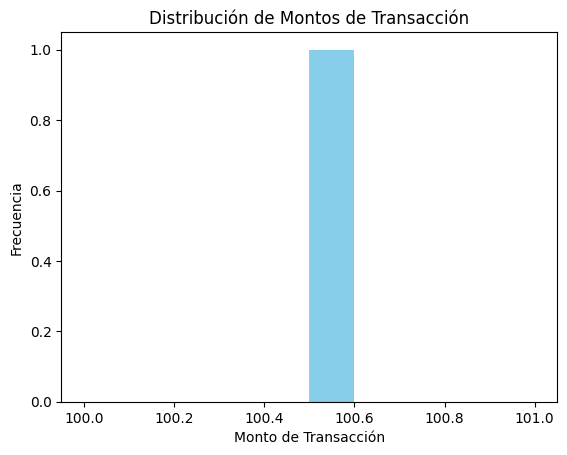

In [71]:
# --- EDA y baseline usando el DataFrame aplanado ---
# Usaremos df_flat y buscaremos la columna de montos de transacción
# Reemplaza 'Total' por el nombre exacto de la columna si es diferente

# Busca la columna que contenga 'Total' (insensible a mayúsculas)
amount_col = None
for col in df_flat.columns:
    if 'total' in col.lower():
        amount_col = col
        break

if amount_col:
    print(f"Columna de montos detectada: {amount_col}")
    print(df_flat[amount_col].describe())
    # Creamos variable binaria para baseline
    df_flat['es_alto_monto'] = (df_flat[amount_col] > df_flat[amount_col].median()).astype(int)
    from sklearn.model_selection import train_test_split
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    X = df_flat[[amount_col]].fillna(0)
    y = df_flat['es_alto_monto']
    # Filtra filas válidas (quita NaN y asegura que hay al menos 2 muestras)
    valid_idx = X[amount_col].notna() & y.notna()
    X_valid = X[valid_idx]
    y_valid = y[valid_idx]
    if len(X_valid) > 1:
        X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.3, random_state=42)
        if len(X_train) > 0 and len(X_test) > 0:
            dummy = DummyClassifier(strategy='most_frequent')
            dummy.fit(X_train, y_train)
            y_pred = dummy.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            print('Métricas del baseline:')
            print(f'Accuracy: {acc:.2f}')
            print(f'F1 Score: {f1:.2f}')
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title('Matriz de confusión del baseline')
            plt.show()
        else:
            print('No hay suficientes datos para dividir en train/test.')
    else:
        print('No hay suficientes muestras válidas para baseline (se requiere al menos 2).')
    # Histograma
    plt.hist(df_flat[amount_col].dropna(), bins=10, color='skyblue')
    plt.xlabel('Monto de Transacción')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Montos de Transacción')
    plt.show()
else:
    print('No se encontró ninguna columna de montos (Total) en el DataFrame aplanado.')